In [7]:
%matplotlib inline
from IPython.display import Latex, display
import numpy as np
from numpy import genfromtxt
import scipy as sp
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import Markdown
import seaborn as sns
from scipy.interpolate import interp1d
import datetime
from astropy.time import Time
from datetime import timedelta
import pandas as pd

plt.style.use('default')
params = {'legend.fontsize': '20',
          'figure.figsize': (18, 10),
         'axes.labelsize': '18',
         'axes.titlesize':'25',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.minor.visible' : True,
         'ytick.minor.visible' : True,
         'axes.grid' : True,
         'grid.linewidth' : '0.5',
         'grid.linestyle' : '-',
         'text.usetex': False,
         'svg.fonttype': 'none'}
plt.rcParams.update(params)

# 1) Analyse AX Vel

In [153]:
#quelques données 
P = 2.592891 #period AX Vel [day]
Mid = 2443618.9639 #epoch [HJD] (2443878.253)

a = 8.1 # HD 68395 mag V
b = 8.25 # HD 68515 mag V
c = 8.56 # HD 68630 mag V
d = 8.59 # HD 68477 mag V

def f_phase(date):
    return np.mod((date-Mid)/P,1)

def f_mag(target,comparison,comparison_mag):
    return -2.5*(np.log10(target/comparison))+comparison_mag

def Walraven_to_Johnson(V,V_B): 
    return 6.874 -2.5*(V + 0.065*V_B) #from Barrell's article

#Ouverture des datas
data_brut = pd.read_csv('data_fromIRIS.txt',sep="\t",index_col=False)
air_mass = pd.read_csv('air_mass.txt',index_col=False)

#Ajout n° d'observation
n_obs = [i//10 for i in range(10,len(data_brut)+10)]
n_obs_mean = [i for i in range(1,int((len(data_brut)+10)/10))]
data_brut.insert(0, 'n° observation', n_obs)

#calcul mag
results_brut = pd.DataFrame({'n° observation' : n_obs,
                           'phase': f_phase(data_brut['date [HJD]']),
                           'AX Vel from a': f_mag(data_brut['AX Vel [ADU]'],data_brut['HD 68395 [ADU]'],a),
                           'AX Vel from b': f_mag(data_brut['AX Vel [ADU]'],data_brut['HD 68515 [ADU]'],b),
                           'AX Vel from c': f_mag(data_brut['AX Vel [ADU]'],data_brut['HD 68630 [ADU]'],c),
                           'AX Vel from d': f_mag(data_brut['AX Vel [ADU]'],data_brut['HD 68477 [ADU]'],d),
                           'HD 68395 from b': f_mag(data_brut['HD 68395 [ADU]'],data_brut['HD 68515 [ADU]'],b),
                           'HD 68395 from c': f_mag(data_brut['HD 68395 [ADU]'],data_brut['HD 68630 [ADU]'],c),
                           'HD 68395 from d': f_mag(data_brut['HD 68395 [ADU]'],data_brut['HD 68477 [ADU]'],d)})

#calcul mean
date_middle = data_brut.groupby('n° observation')['date [HJD]'].nth(5)
phase_mean = results_brut.groupby('n° observation')['phase'].mean()
AX_mean_mag = results_brut.groupby('n° observation')['AX Vel from a',
                                                        'AX Vel from b',
                                                        'AX Vel from c',
                                                        'AX Vel from d'].mean().mean(axis=1)
AX_std_mag = results_brut.groupby('n° observation')['AX Vel from a',
                                                        'AX Vel from b',
                                                        'AX Vel from c',
                                                        'AX Vel from d'].std().mean(axis=1)
AX_mean_adu = data_brut.groupby('n° observation')['AX Vel [ADU]'].mean()
AX_std_adu = data_brut.groupby('n° observation')['AX Vel [ADU]'].std()
HD_mean = results_brut.groupby('n° observation')['HD 68395 from b',
                                                    'HD 68395 from c',
                                                    'HD 68395 from d'].mean().mean(axis=1)
HD_std_mag = results_brut.groupby('n° observation')['HD 68395 from b',
                                                    'HD 68395 from c',
                                                    'HD 68395 from d'].std().mean(axis=1)


results = pd.DataFrame({'n° observation' : n_obs_mean,
                             'date [HJD]' : date_middle.values,
                             'phase': phase_mean.values,
                             'mean AX Vel [mag]' : AX_mean_mag.values,
                             'std AX Vel [mag]' : AX_std_mag.values,
                             'mean AX Vel [ADU]' : AX_mean_adu.values,
                             'std AX Vel [ADU]' : AX_std_adu.values,
                             'mean HD 68395 [mag]' : HD_mean.values,
                             'std HD 68395 [mag]' : HD_std_mag.values,
                             'air mass [x masse zénithale]': air_mass["air mass [x masse d'air zenithale]"]
                            })


data_brut.to_csv('nos_donnes/data_brut.txt',index=False)
results.to_csv('nos_donnes/results.txt',index=False)
results_brut.to_csv('nos_donnes/results_brut.txt',index=False)

results

,n° observation,date [HJD],phase,mean AX Vel [mag],std AX Vel [mag],mean AX Vel [ADU],std AX Vel [ADU],mean HD 68395 [mag],std HD 68395 [mag],air mass [x masse zénithale]
0,1,2459331.884,0.000363,8.273538,0.025387,111824.3,1527.493739,8.098666,0.036046,1.0813
1,2,2459350.992,0.369550,8.019474,0.144441,3427.6,231.768659,8.756213,0.185084,1.9480
2,3,2459353.925,0.500604,8.013141,0.046620,136445.1,5631.823436,8.089311,0.021911,1.4130
3,4,2459354.901,0.877211,8.280928,0.021067,105014.5,2272.641451,8.128118,0.044764,1.3020
4,5,2459355.872,0.251812,8.319940,0.017255,105792.5,1155.546840,8.099130,0.018468,1.2040
5,6,2459356.867,0.635399,8.172680,0.020195,121763.4,2069.180847,8.082167,0.013566,1.1960
6,7,2459363.964,0.372306,8.195981,0.021042,104853.5,1135.267492,8.083715,0.026018,2.0770
7,8,2459365.922,0.127794,8.244653,0.031867,82500.1,3729.514191,8.073431,0.029990,1.6460


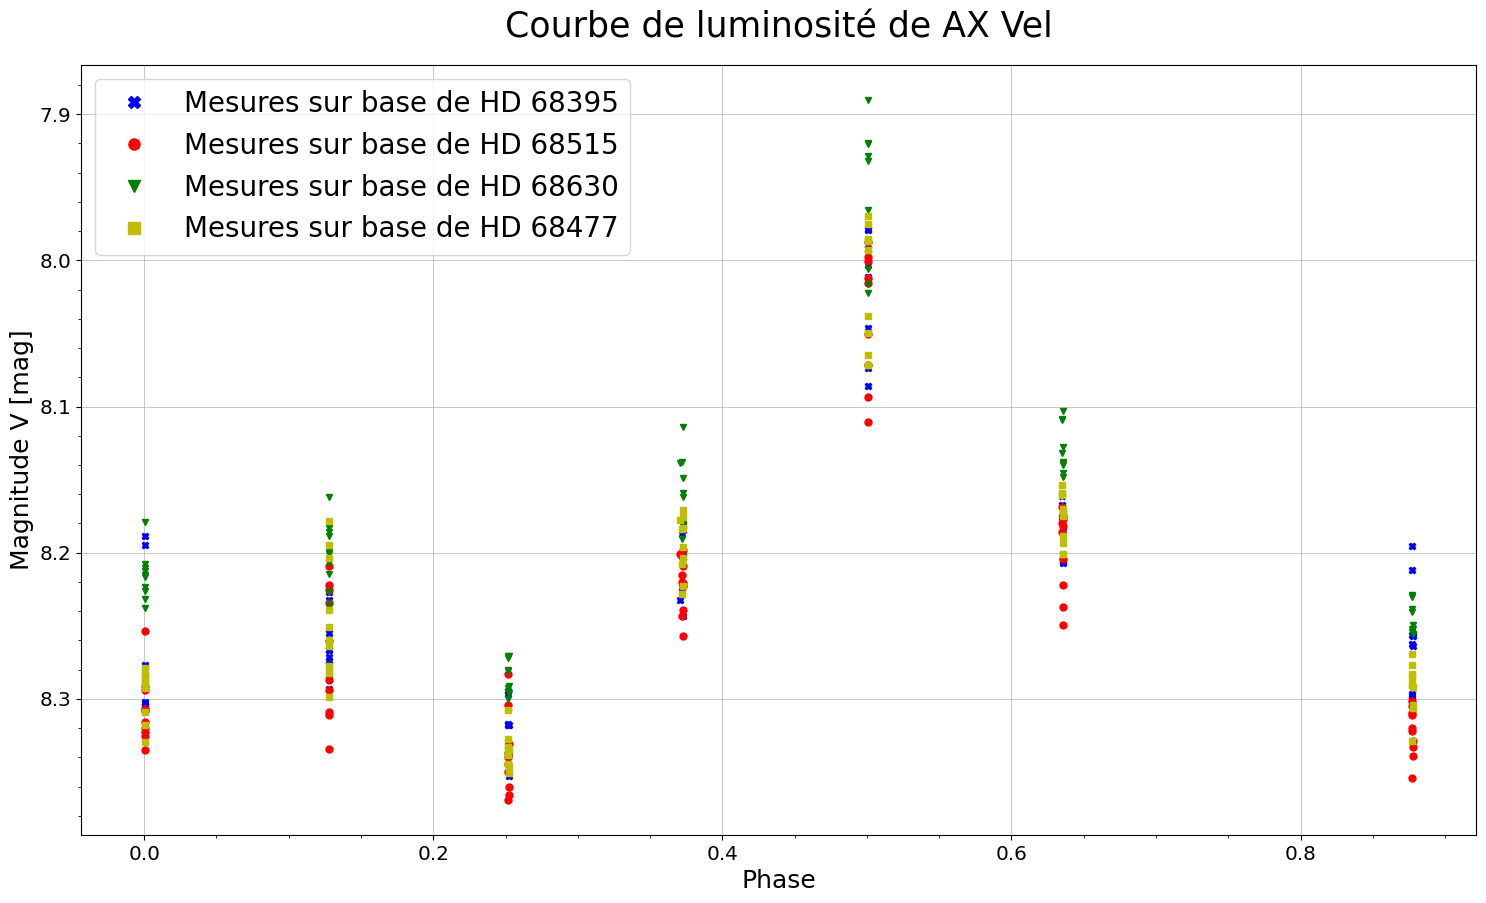

In [78]:
#Retrait observation 16 mai 

results_brut_crop = results_brut.drop(results_brut.index[10:21])

fig, ax = plt.subplots()

ax.plot(results_brut_crop['phase'], results_brut_crop['AX Vel from a'],
        lw=1, color='b', marker='X',linestyle = 'none', markersize=5, label=('Mesures sur base de HD 68395'))
ax.plot(results_brut_crop['phase'], results_brut_crop['AX Vel from b'],
        lw=1, color='r', marker='o',linestyle = 'none', markersize=5, label=('Mesures sur base de HD 68515'))
ax.plot(results_brut_crop['phase'], results_brut_crop['AX Vel from c'],
        lw=1, color='g', marker='v',linestyle = 'none', markersize=5, label=('Mesures sur base de HD 68630'))
ax.plot(results_brut_crop['phase'], results_brut_crop['AX Vel from d'],
        lw=1, color='y', marker='s',linestyle = 'none', markersize=5, label=('Mesures sur base de HD 68477'))

ax.invert_yaxis()

ax.set_title('Courbe de luminosité de AX Vel', pad=20)
ax.set_ylabel('Magnitude V [mag]')
ax.set_xlabel('Phase')
lgnd = ax.legend(loc='best', frameon=True, markerscale = 0.7)


lgnd.legendHandles[0]._legmarker.set_markersize(8)
lgnd.legendHandles[1]._legmarker.set_markersize(8)
lgnd.legendHandles[2]._legmarker.set_markersize(8)
lgnd.legendHandles[3]._legmarker.set_markersize(8)

plt.show()

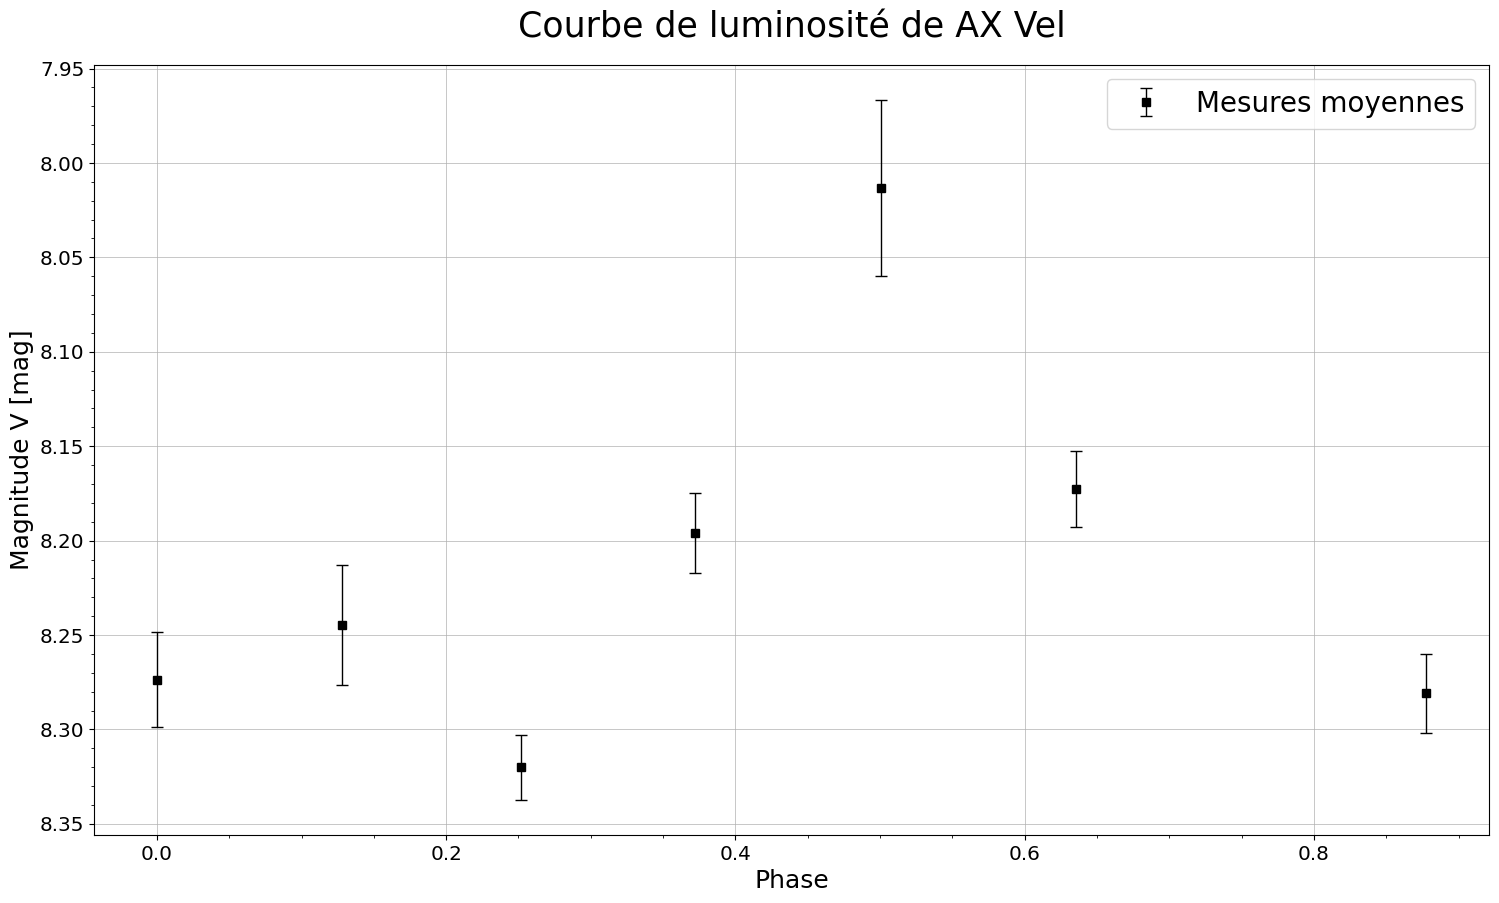

In [74]:
#Retrait observation 16 mai 
results_crop = results.drop([1])
    
fig, ax = plt.subplots()


ax.errorbar(results_crop['phase'], results_crop['mean AX Vel [mag]'], yerr=results_crop['std AX Vel [mag]'],
            lw=1, color='k',  capsize=4, marker='s',linestyle = 'none', label=('Mesures moyennes'))

ax.invert_yaxis()

ax.set_title('Courbe de luminosité de AX Vel', pad=20)
ax.set_ylabel('Magnitude V [mag]')
ax.set_xlabel('Phase')
ax.legend(loc='best', frameon=True)

plt.show()

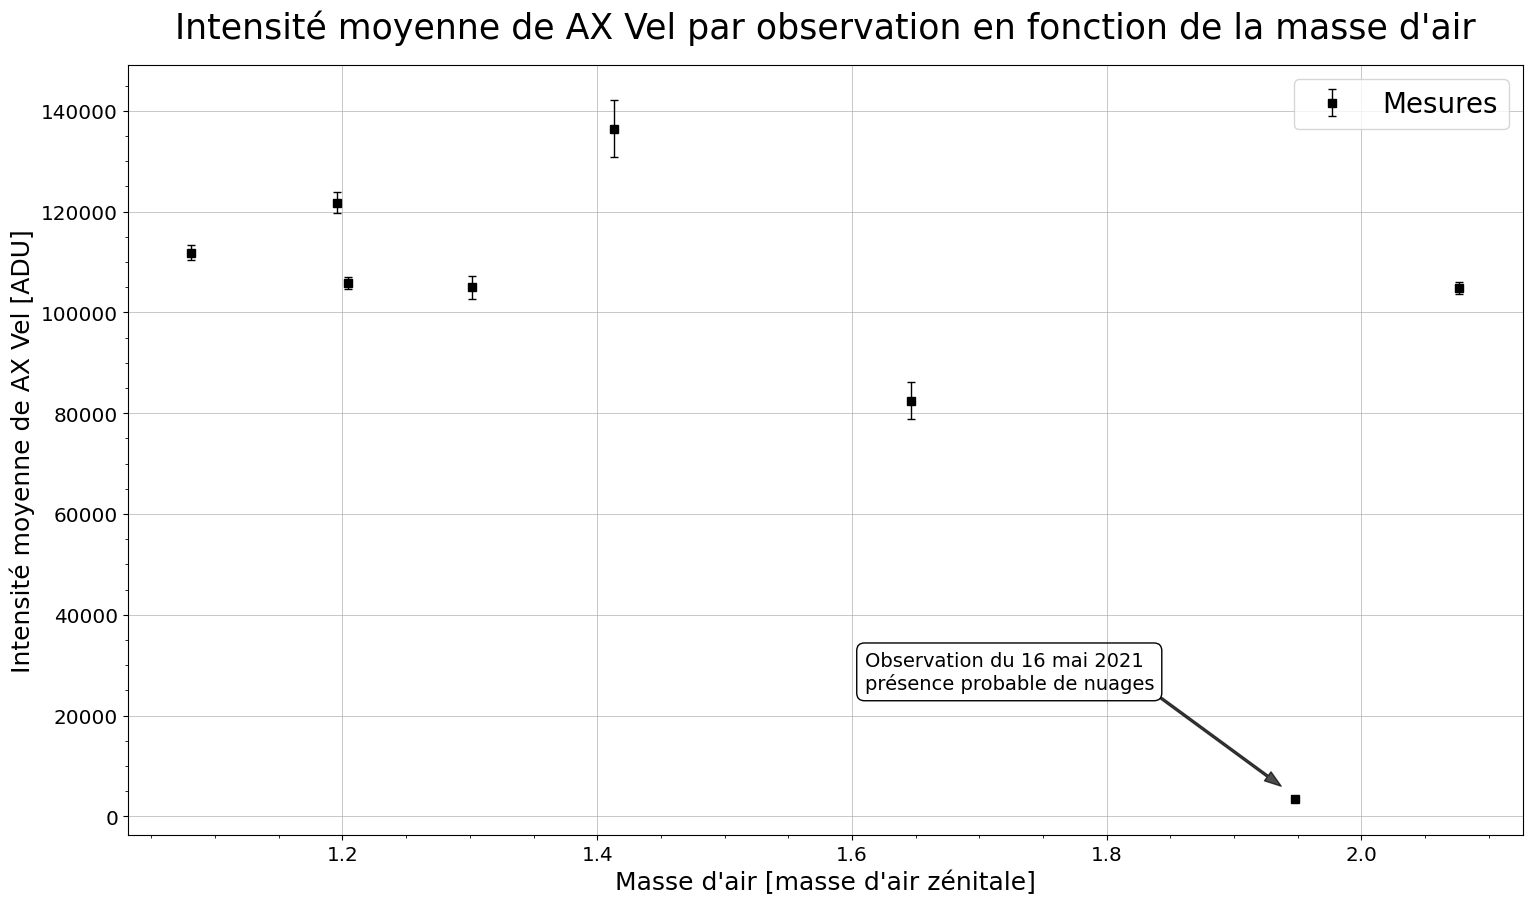

In [29]:
fig3, ax3 = plt.subplots()

ax3.errorbar(results["air mass [x masse zénithale]"], results["mean AX Vel [ADU]"], yerr=results["std AX Vel [ADU]"], lw=1, color='k',  capsize=3, marker='s',
            linestyle = 'none', label=('Mesures'))

ax3.set_title("Intensité moyenne de AX Vel par observation en fonction de la masse d'air", pad=20)
ax3.set_ylabel("Intensité moyenne de AX Vel [ADU]")
ax3.set_xlabel("Masse d'air [masse d'air zénitale]")
ax3.legend(loc='best', frameon=True)



ax3.annotate('Observation du 16 mai 2021\nprésence probable de nuages', xy = (1.937, 6000),  xycoords='data',
                xytext = (-300,70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

plt.savefig('graphes/meanadu_airmass.pdf', bbox_inches='tight')
plt.show()

# 2) Validation photométrie

In [30]:
t = Time([results['date [HJD]']], format='jd', out_subfmt='date')
date2 = t.tt.datetime[0]

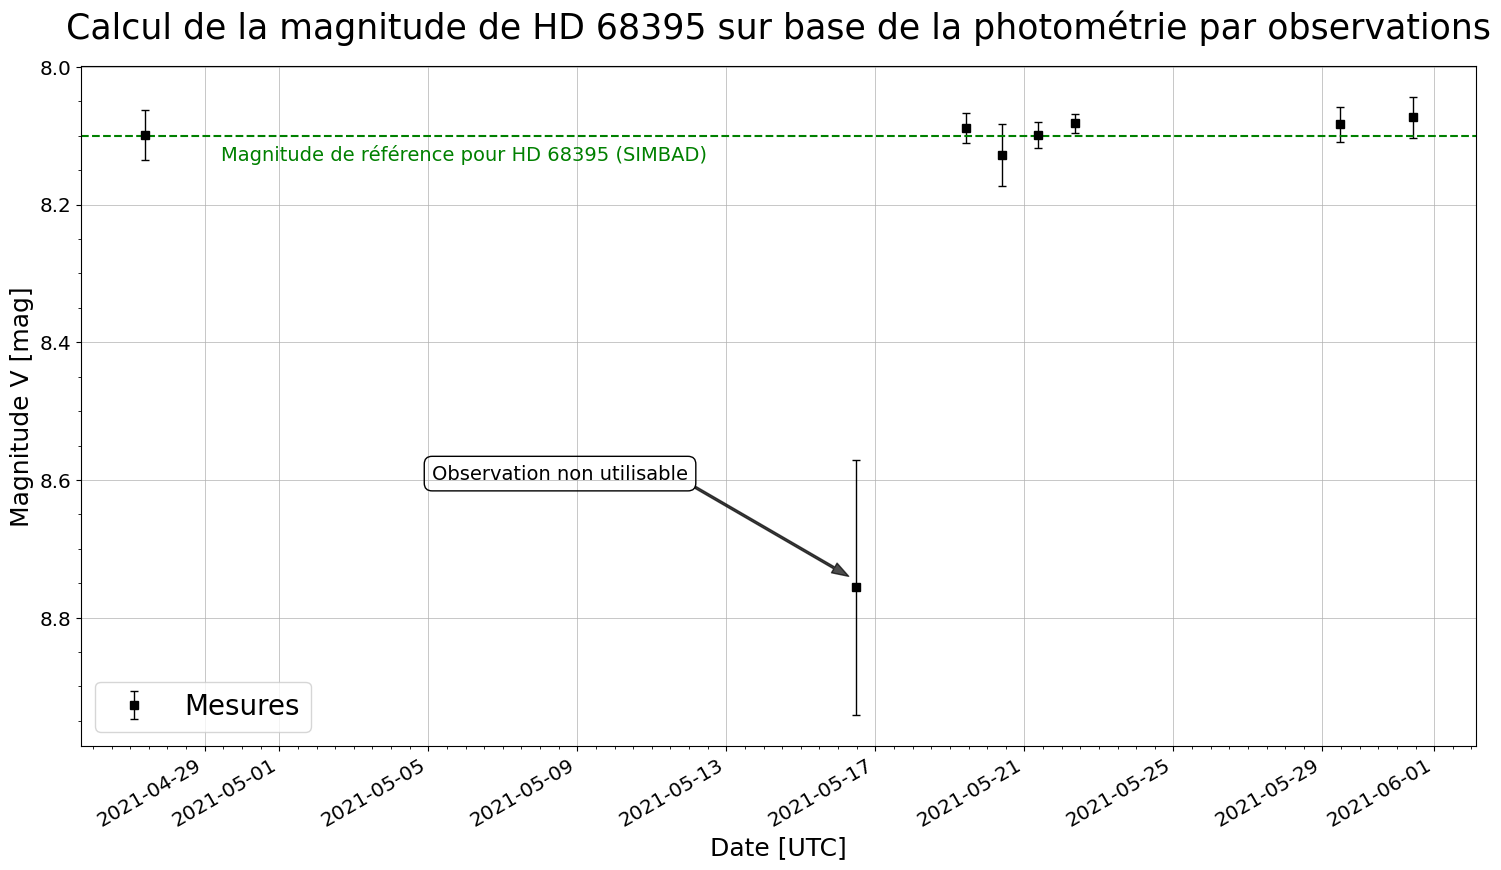

In [31]:
fig4, ax4 = plt.subplots()

ax4.errorbar(date2, results['mean HD 68395 [mag]'], yerr=results['std HD 68395 [mag]'], lw=1, color='k',  capsize=3, marker='s',linestyle = 'none', label=('Mesures'))

ax4.set_title('Calcul de la magnitude de HD 68395 sur base de la photométrie par observations', pad=20)
ax4.set_ylabel('Magnitude V [mag]')
ax4.set_xlabel("Date [UTC]")
ax4.legend(loc='best', frameon=True)
ax4.invert_yaxis()

ax4.axhline(y=8.1, color='g', linestyle='--')
ax4.text(0.1, 0.86,'Magnitude de référence pour HD 68395 (SIMBAD)',
                fontsize=14, color='green', transform=ax4.transAxes)

ax4.annotate('Observation non utilisable', xy = (date2[1]-timedelta(days=0, hours=5, minutes=0), 8.74),
                xycoords='data',
                xytext = (-300,70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

plt.gcf().autofmt_xdate()
plt.savefig('graphes/HD_check.pdf', bbox_inches='tight')
plt.show()

# 3) Comparaison avec les données de l'article de Susan L. Barrell et de R.S. Stobie

In [151]:
#Ouverture des datas de susan
data_barrell = pd.read_csv('donnes_articles/data_Barrell.txt',sep=",",index_col=False)
data_barrell = (data_barrell[data_barrell['V [mag]'] < 8.6]) # valeur qui deconne en 8.8
date_barrell = data_barrell['HJD (-2443000)'] + 2443000
mag_barrell = data_barrell['V [mag]']
phase_barrell = f_phase(date_barrell)

barrell = pd.DataFrame({'date [HJD]': date_barrell,
                              'V [mag]': mag_barrell,
                              'V-B [mag]' : np.nan,
                              'source': "Barrell",
                              'note': np.nan})

#Ouverture des datas de stobie hawarden
data_stobie_hawarden = pd.read_csv('donnes_articles/data_Stobie_Hawarden.txt',sep=",",index_col=False)
date_stobie_hawarden = data_stobie_hawarden['HJD (-2400000)'] + 2400000
mag_stobie_hawarden = data_stobie_hawarden['V [mag]']
phase_stobie_hawarden = f_phase(date_stobie_hawarden)

stobie_hawarden = pd.DataFrame({'date [HJD]': date_stobie_hawarden,
                              'V [mag]': mag_stobie_hawarden,
                              'V-B [mag]' : np.nan,
                              'source': "Stobie et Hawarden",
                              'note': 'Johnson V'})

#Ouverture des datas de stobie balona
data_stobie_balona = pd.read_csv('donnes_articles/data_Stobie_Balona.txt',sep=",",index_col=False)
date_stobie_balona = data_stobie_balona['HJD (-2443000)'] + 2443000
mag_stobie_balona = data_stobie_balona['V [mag]']
phase_stobie_balona = f_phase(date_stobie_balona)

stobie_balona = pd.DataFrame({'date [HJD]': date_stobie_balona,
                              'V [mag]': mag_stobie_balona,
                              'V-B [mag]' : np.nan,
                              'source': "Stobie et Balona",
                              'note': 'Johnson V'})

#Ouverture des datas de dean
data_dean = pd.read_csv('donnes_articles/data_Dean.txt',sep=",",index_col=False)
date_dean = data_dean['HJD (-2440000)'] + 2440000
mag_dean = data_dean['V [mag]']
phase_dean = f_phase(date_dean)

dean = pd.DataFrame({'date [HJD]': date_dean,
                              'V [mag]': mag_dean,
                              'V-B [mag]' : np.nan,
                              'source': "Dean",
                              'note': np.nan})

#Ouverture des datas de pel
data_pel = pd.read_csv('donnes_articles/data_Pel.txt',sep=",",index_col=False)
date_pel = data_pel['HJD (-2440000)'] + 2440000
mag_pel = data_pel['V [mag]']
v_b_mag_pel = data_pel['V-B [mag]']
mag_pel_V = Walraven_to_Johnson(mag_pel,v_b_mag_pel)
phase_pel = f_phase(date_pel)

pel = pd.DataFrame({'date [HJD]': date_pel,
                              'V [mag]': mag_pel,
                              'V-B [mag]' : v_b_mag_pel,
                              'source': "Pel",
                              'note': 'Walraven VBLUW'})

#Ouverture des datas de mitchell
data_mitchell = pd.read_csv('donnes_articles/data_Mitchell.txt',sep=",",index_col=False)
date_mitchell = data_mitchell['HJD (-2430000)'] + 2430000
mag_mitchell = data_mitchell['V [mag]']
phase_mitchell = f_phase(date_mitchell)

mitchell = pd.DataFrame({'date [HJD]': date_mitchell,
                              'V [mag]': mag_mitchell,
                              'V-B [mag]' : np.nan,
                              'source': "Mitchell",
                              'note': 'Johnson V'})


grouped_data = pd.concat([barrell,stobie_hawarden,stobie_balona,dean,pel,mitchell], ignore_index=True)
grouped_data.to_csv('donnes_articles/grouped_data.txt',index=False)


print(len(data_barrell),'mesures de Barrell (1983)')
print(len(data_stobie_hawarden),'mesures de Stobie et Hawarden (1972)')
print(len(data_stobie_balona),'mesures de Stobie et Balona (1979)')
print(len(data_dean),'mesures de Dean (1977)')
print(len(data_pel),'mesures de Pel (1976)')
print(len(data_mitchell),'mesures de Mitchell (1964)')
print('----------------------------')
print(len(data_grouped), 'mesures au total')

389 mesures de Barrell (1983)
34 mesures de Stobie et Hawarden (1972)
59 mesures de Stobie et Balona (1979)
5 mesures de Dean (1977)
48 mesures de Pel (1976)
29 mesures de Mitchell (1964)
----------------------------
564 mesures au total


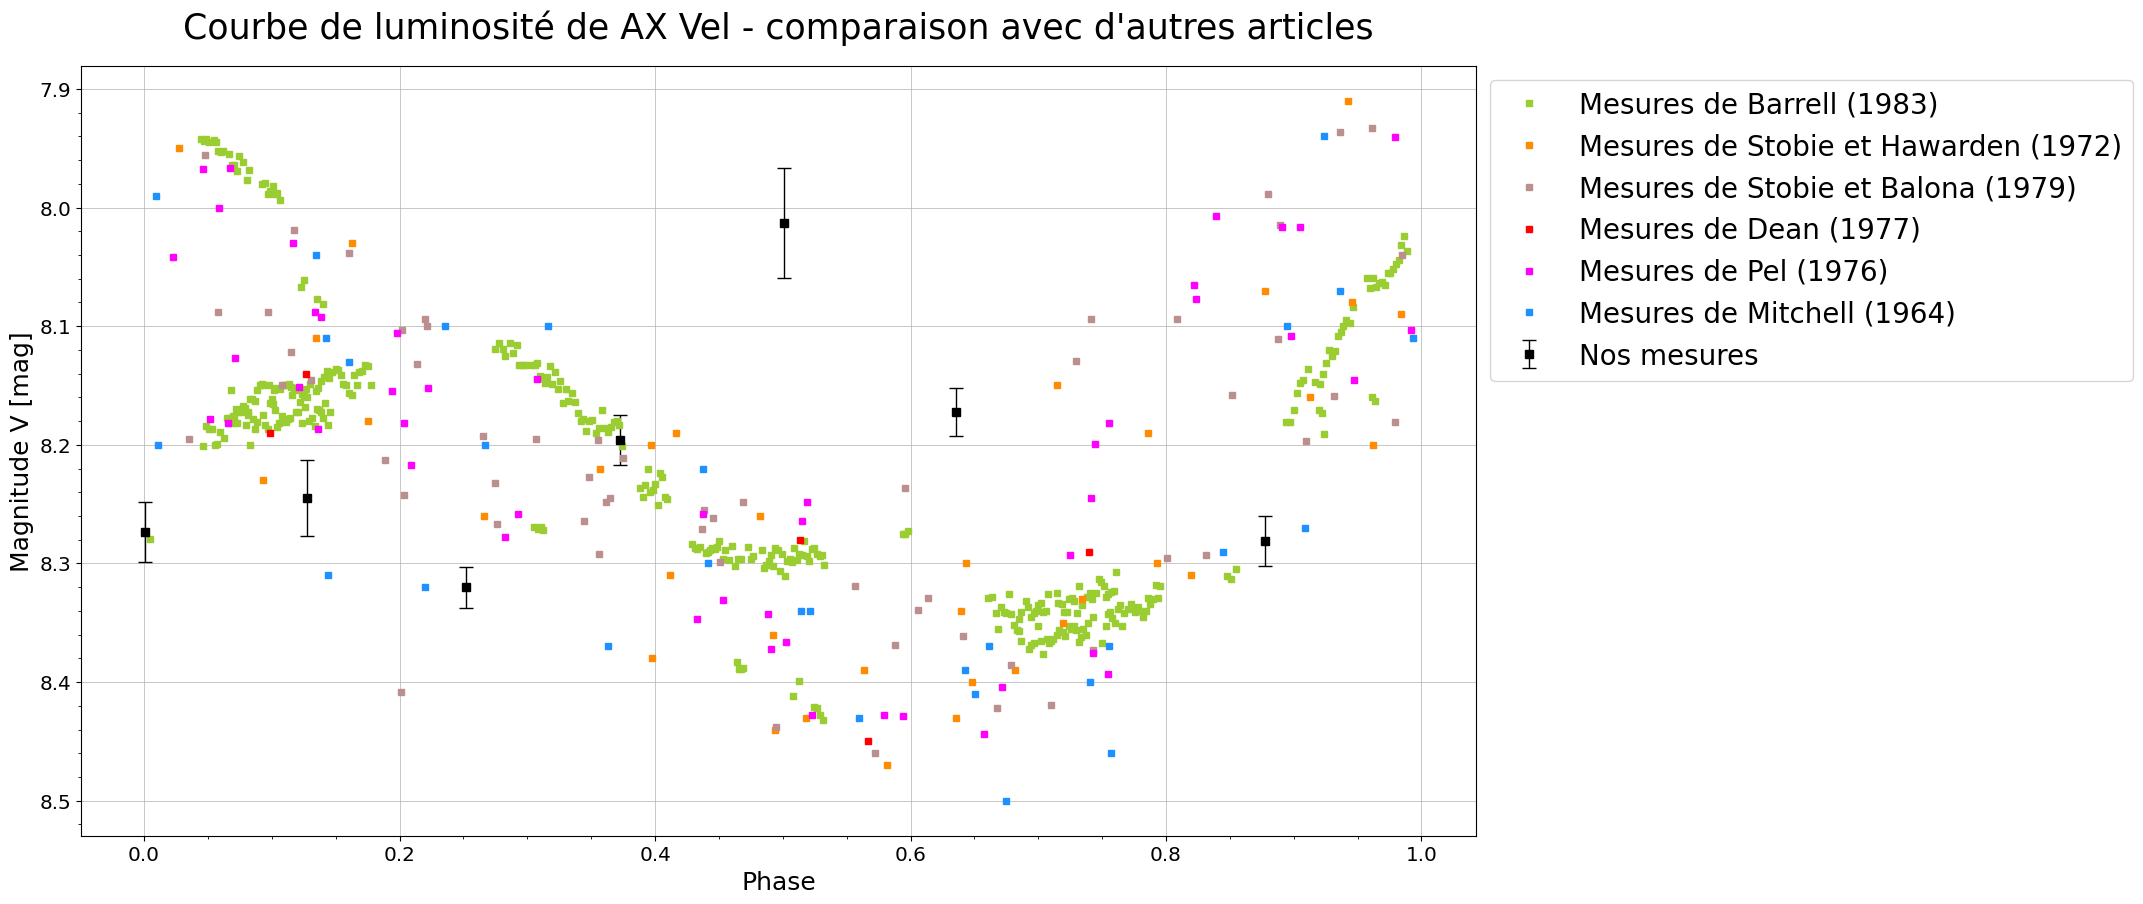

In [152]:
#Retrait observation 16 mai 
results_crop = results.drop([1])

fig_comp, ax_comp = plt.subplots()

ax_comp.plot(phase_barrell, mag_barrell, lw=1, markersize = 4,
             color='yellowgreen', marker='s', linestyle = 'none', label=('Mesures de Barrell (1983)'))
ax_comp.plot(phase_stobie_hawarden, mag_stobie_hawarden, lw=1, markersize = 4,
             color='darkorange', marker='s', linestyle = 'none', label=('Mesures de Stobie et Hawarden (1972)'))
ax_comp.plot(phase_stobie_balona, mag_stobie_balona, lw=1, markersize = 4,
             color='rosybrown', marker='s', linestyle = 'none', label=('Mesures de Stobie et Balona (1979)'))
ax_comp.plot(phase_dean, mag_dean, lw=1, markersize = 4,
             color='r', marker='s', linestyle = 'none', label=('Mesures de Dean (1977)'))
ax_comp.plot(phase_pel, mag_pel_V, lw=1, markersize = 4,
             color='fuchsia', marker='s', linestyle = 'none', label=('Mesures de Pel (1976)'))
ax_comp.plot(phase_mitchell, mag_mitchell, lw=1, markersize = 4,
             color='dodgerblue', marker='s', linestyle = 'none', label=('Mesures de Mitchell (1964)'))

#ax_comp.errorbar(results_crop['phase'], results_crop['mean AX Vel [mag]'], yerr=results_crop['std AX Vel [mag]'],
#                 lw=1, color='k',  capsize=5, marker='s', linestyle = 'none', label=('Nos mesures'))


ax_comp.invert_yaxis()
ax_comp.set_title("Courbe de luminosité de AX Vel - comparaison avec d'autres articles", pad=20)
ax_comp.set_ylabel('Magnitude V [mag]')
ax_comp.set_xlabel('Phase')
ax_comp.legend(loc='best', frameon=True, bbox_to_anchor=(1.0, 1.0)) #, fontsize='15'

plt.savefig('graphes/litterature_vs_nous.pdf', bbox_inches='tight')
plt.show()

# 4) Estimation de la distance de AX Vel

In [141]:
p_gaia = 0.6799677466559306e-3 #arcsec
D_th = 1/p_gaia


a = -4.05
b = -2.43
P = 2.592891
m_V = np.mean(results.drop([1])['mean AX Vel [mag]']) #sans l'observation raté du 16 mai
K = 6.403
A = 0

M = a + b*(np.log10(P) - 1)
D = 10**((m_V - M + 5 - A) / 5)
err = np.abs((1 - (D/D_th))*100)

print('D =',"{:.2f}".format(D),'[pc]')
print('D_GAIA =',"{:.2f}".format(D_th),'[pc]')
print('Erreur de',"{:.2f}".format(err),'%','par rapport à Gaia')

D = 1472.25 [pc]
D_GAIA = 1470.66 [pc]
Erreur de 0.11 % par rapport à Gaia


# 5) PSF saturé

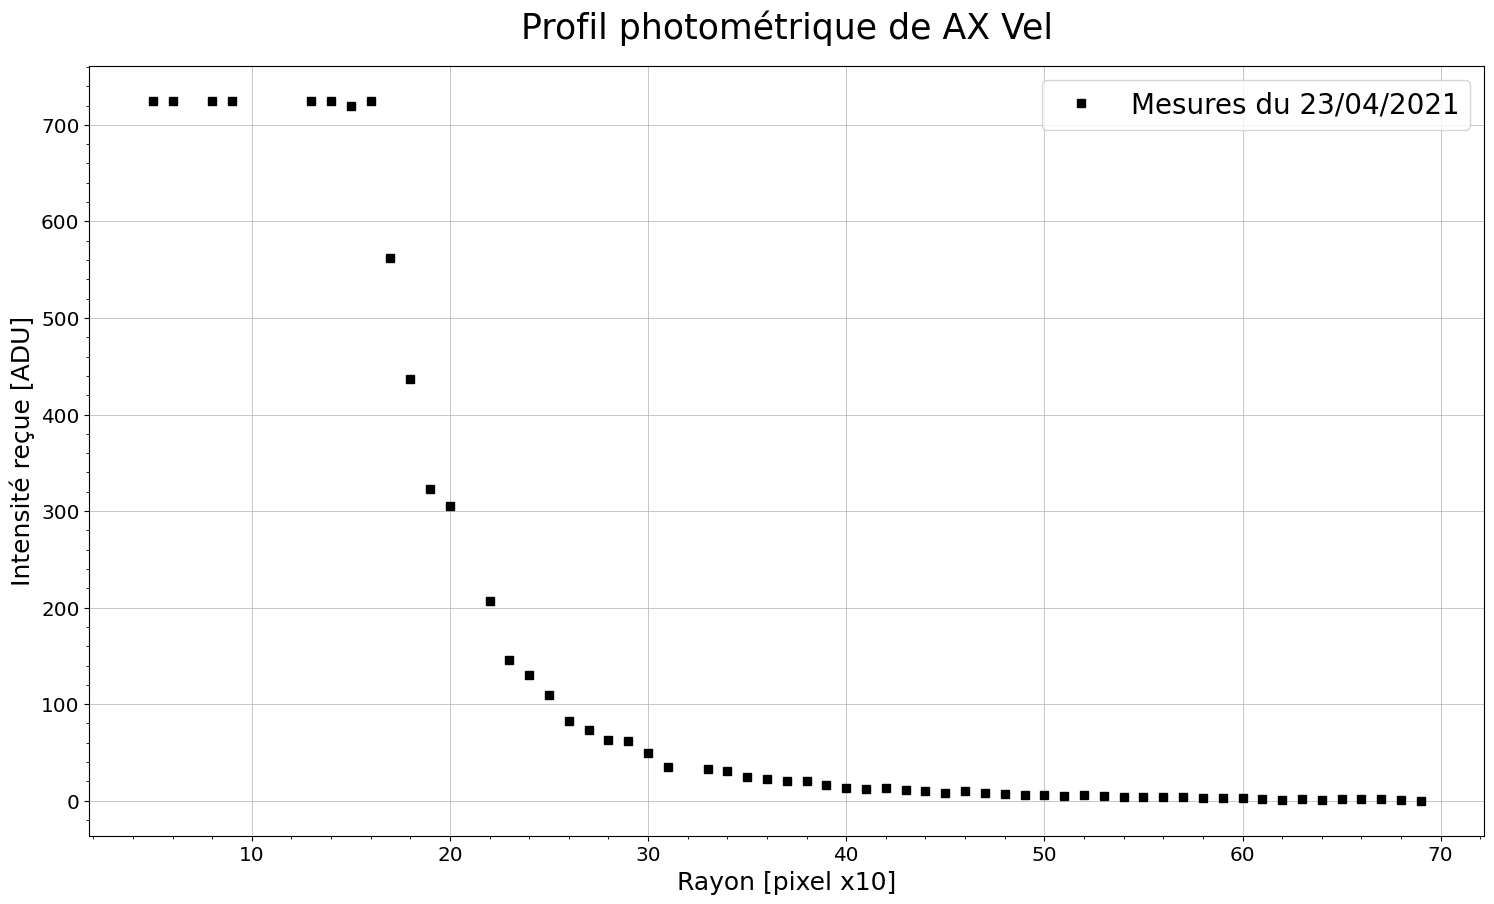

In [154]:
#PSF AX Vel saturé
data_sature = pd.read_csv('obs_23_avril_sature.txt',sep=" ",index_col=False, na_values=['-9999'])

#Encodage des datas, selectionner datas 1 to 70: 1= enlever le max 70= cropper les datas
radius = data_sature.iloc[1:70 , 0]
sat_adu = data_sature.iloc[1:70 , 1]

figsat, axsat = plt.subplots()

axsat.plot(radius, sat_adu, color='k', marker = 's', linestyle = "none", label = "Mesures du 23/04/2021")

axsat.set_title('Profil photométrique de AX Vel', pad=20)
axsat.set_xlabel('Rayon [pixel x10]')
axsat.set_ylabel("Intensité reçue [ADU]")
axsat.legend(loc='best', frameon=True)

plt.savefig('graphes/sature.pdf', bbox_inches='tight')
plt.show()

# 6) Etude reglages télescope

In [155]:
#images fournies pour HD5505 - T5
data_T5 = pd.read_csv('ADU_HD5505_T5.txt',sep=",",index_col=False)

#Encodage des datas séparation lineaire et quadratique
hd5505_t1 = data_T5.iloc[0:5 , 0]
hd5505_adu1 = data_T5.iloc[0:5 , 1]

hd5505_t2 = data_T5.iloc[5:12 , 0]
hd5505_adu2 = data_T5.iloc[5:12 , 1]

#fit linéaire
coef1 = np.polyfit(hd5505_t1, hd5505_adu1, 1)
print("fit linéaire : f(x) =",coef1[0],"x +",coef1[1])
#fit ^2
coef2 = np.polyfit(hd5505_t2, hd5505_adu2, 2)
print("fit quadratique : g(x) =",coef2[0],"x^2 +",coef2[1],"x +",coef2[2])

fit1 = np.poly1d(coef1)
fit2 = np.poly1d(coef2)

x1 = np.linspace(1,24,100)
x2 = np.linspace(12,62,100)

x_int = 17.8
y_int = 232141

fit linéaire : f(x) = 13040.472560975606 x + 29.03048780490971
fit quadratique : g(x) = -66.2338643146685 x^2 + 12385.324945431847 x + 32687.848857410852


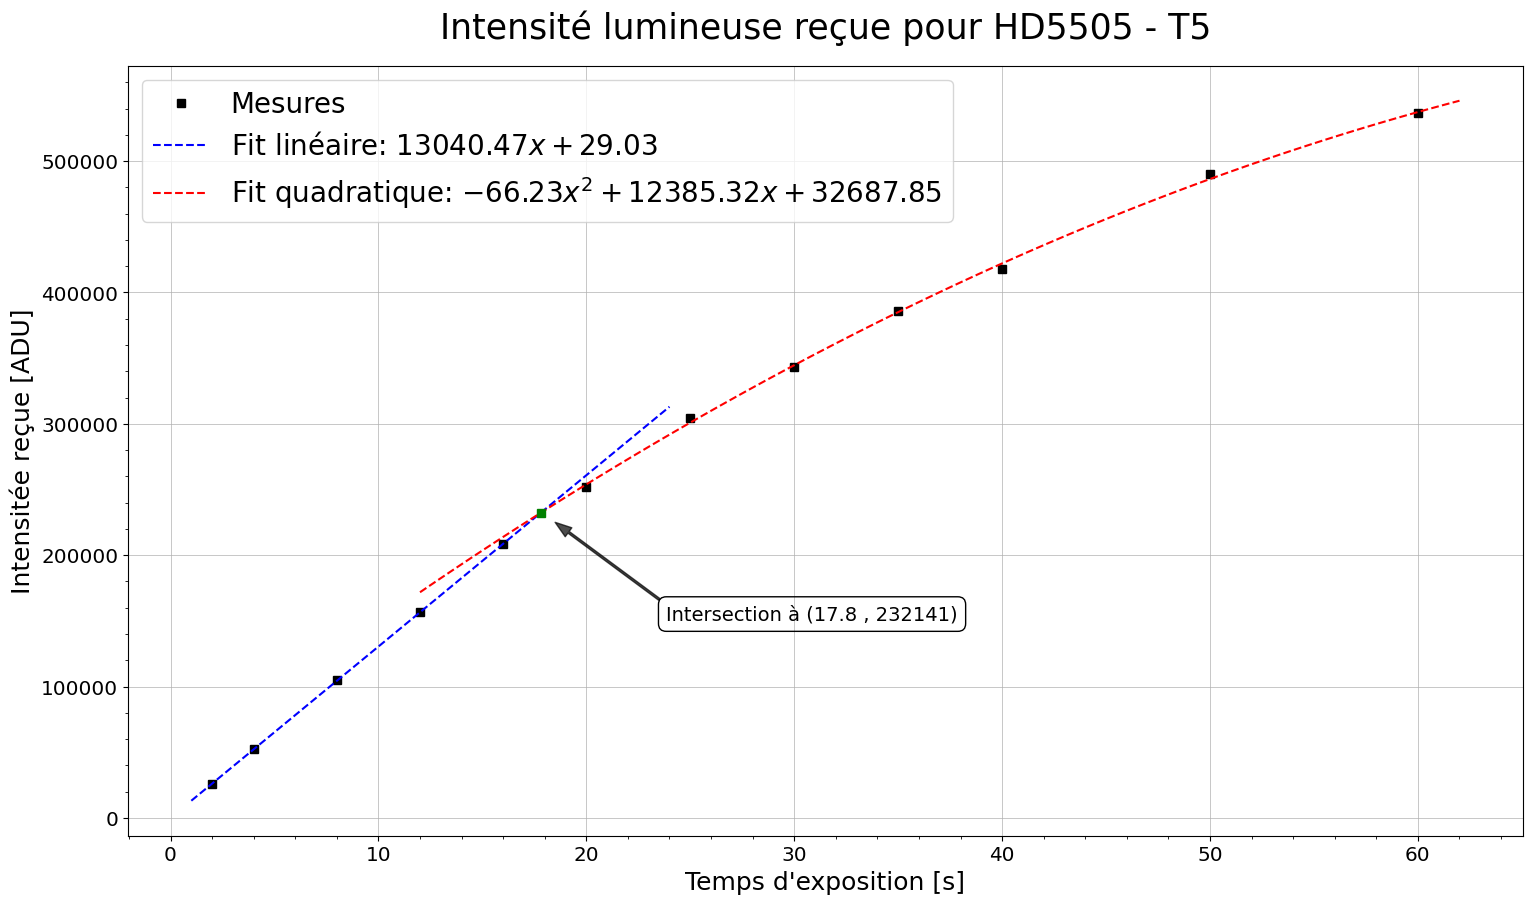

In [156]:
fig0, ax0 = plt.subplots()

ax0.plot(data_T5['exposure [s]'], data_T5['ADU'], color='k', marker='s', linestyle = 'none', label = 'Mesures')

ax0.plot(x1, fit1(x1), color='b', linestyle = '--', label=('Fit linéaire: $13040.47 x + 29.03$'))
ax0.plot(x2, fit2(x2), color='r', linestyle = '--', label=('Fit quadratique: $-66.23 x^2 + 12385.32 x + 32687.85$'))


ax0.plot(x_int, y_int, color='g', marker='s')

ax0.annotate('Intersection à (17.8 , 232141)', xy = (18.5, 225000), xycoords='data',
                xytext = (80,-70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

ax0.set_title('Intensité lumineuse reçue pour HD5505 - T5', pad=20)
ax0.set_ylabel('Intensitée reçue [ADU]')
ax0.set_xlabel("Temps d'exposition [s]")
ax0.legend(loc='best', frameon=True)

plt.savefig('graphes/HD5505_T5.pdf', bbox_inches='tight')
plt.show()

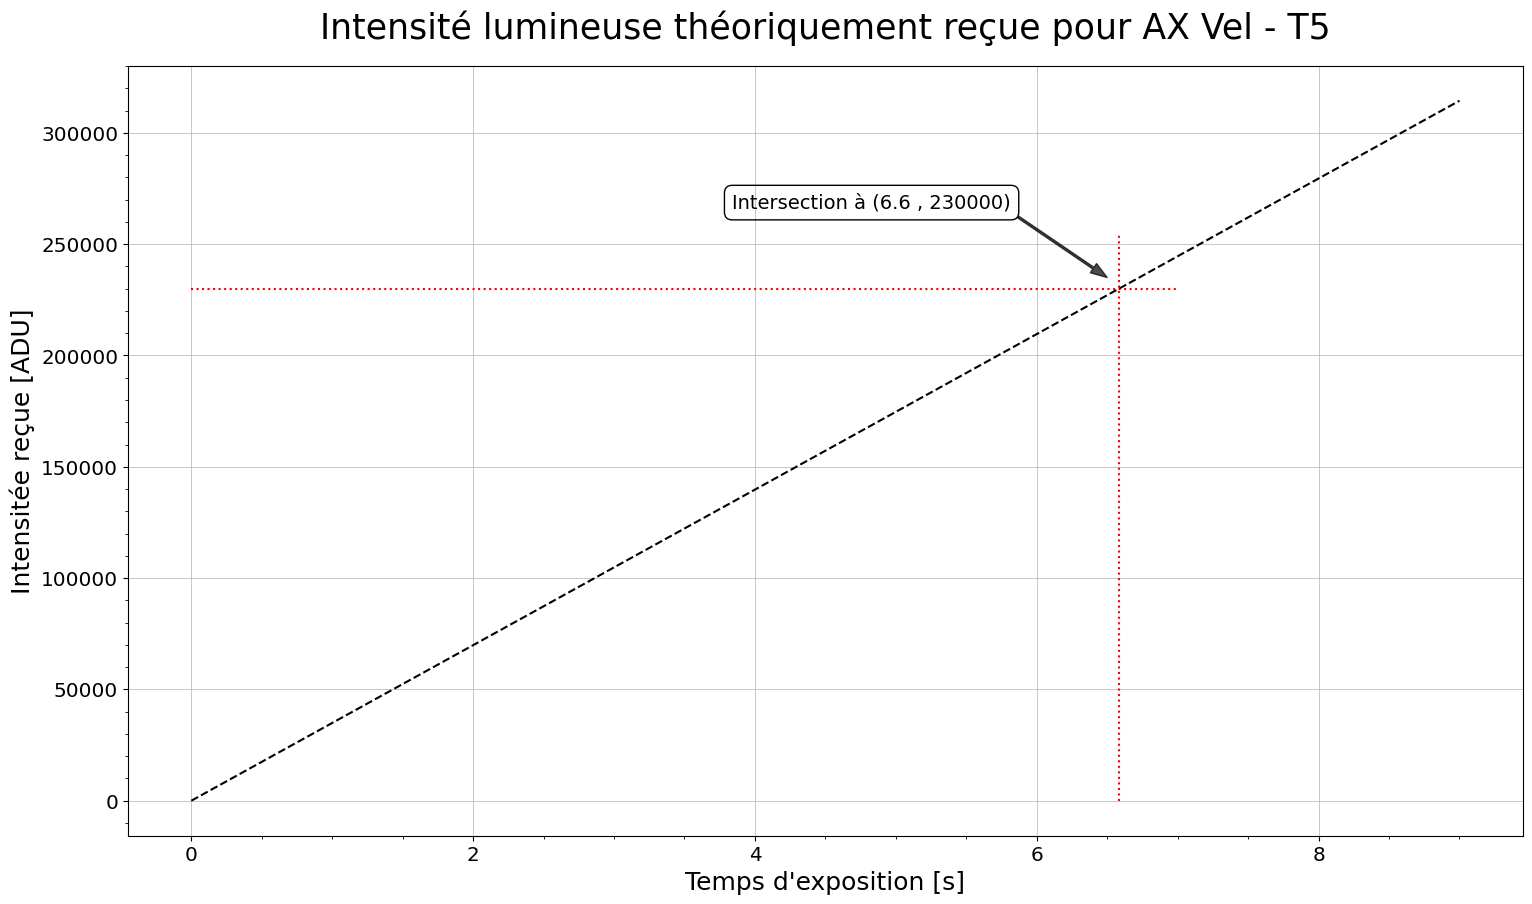

In [150]:
coefn = 34936, 0
fitn = np.poly1d(coefn)
xn = np.linspace(0,9,100)

fign, axn = plt.subplots()

axn.plot(xn, fitn(xn), color='k', linestyle = '--')
axn.hlines(230000,0,7,colors='r', linestyles='dotted')
axn.vlines(6.58346691092283,0,255000,colors='r', linestyles='dotted')

axn.annotate('Intersection à (6.6 , 230000)', xy = (6.5, 235000), xycoords='data',
                xytext = (-270,50 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)



axn.set_title('Intensité lumineuse théoriquement reçue pour AX Vel - T5', pad=20)
axn.set_ylabel('Intensitée reçue [ADU]')
axn.set_xlabel("Temps d'exposition [s]")
#axn.legend(loc='best', frameon=True)

plt.savefig('graphes/AXVEL_T5.pdf', bbox_inches='tight')
plt.show()